<a href="https://colab.research.google.com/github/manuvikash/Drawing-Classifier/blob/main/Drawing_Classifier_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This file contains a subset of the quick draw classes. I choose around 100 classes from the dataset. 

In [1]:
!wget 'https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt'
#Downloads textfile containing subset of 100 labels

'wget' is not recognized as an internal or external command,
operable program or batch file.


Read the classes names 

In [2]:
f = open("labels.txt","r")
classes = f.readlines()
#reading the file
f.close()

In [3]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

# Download the Dataset 

Loop over the classes and download the currospondent data

In [5]:
!mkdir data

In [6]:
import urllib.request
def download():
    base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    for c in classes:        
        cls_url = c.replace('_', '%20')
        path = base+cls_url+'.npy'
        print(path)
        urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [7]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/grapes.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dat

# Imports 

In [4]:
import os
import glob
import numpy as np
from tensorflow.python.keras import layers
from tensorflow import keras 
import tensorflow as tf

print(len(os.listdir('data')))

100


# Load the Data 

Loading 4000 images from every class due to storage and computing power limitations.  

In [5]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [6]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [9]:
print(x_train.shape) #Training-Testing split is 80-20

(320000, 784)


Display a random image

IndexError: index 102517 is out of bounds for axis 0 with size 80000

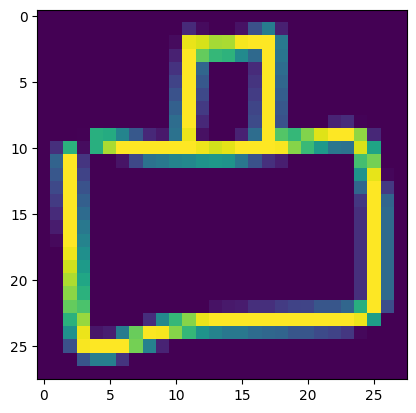

In [13]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28))
img = x_test[idx]
print(x_train[idx].reshape(28,28).shape) 
print(class_names[int(y_train[idx].item())])

# Preprocess the Data 

In [9]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')
x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The Model 

In [11]:
x_train.shape

(320000, 28, 28, 1)

In [57]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=(28, 28, 1), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2),input_shape=(28, 28, 1)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu',input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2),input_shape=(28, 28, 1)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu',input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D(pool_size =(2,2),input_shape=(28, 28, 1)))
model.add(layers.Flatten(input_shape=(28, 28, 1)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(100, activation='softmax')) 

# Train model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])


# Training 

In [58]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=1, epochs=5)

Epoch 1/5
1125/1125 [==============================] - 54s 48ms/step - loss: 1.8953 - top_k_categorical_accuracy: 0.7845 - val_loss: 1.3669 - val_top_k_categorical_accuracy: 0.8771
Epoch 2/5
1125/1125 [==============================] - 53s 47ms/step - loss: 1.2201 - top_k_categorical_accuracy: 0.8953 - val_loss: 1.1342 - val_top_k_categorical_accuracy: 0.9061
Epoch 3/5
1125/1125 [==============================] - 52s 47ms/step - loss: 1.0615 - top_k_categorical_accuracy: 0.9124 - val_loss: 1.0350 - val_top_k_categorical_accuracy: 0.9152
Epoch 4/5
1125/1125 [==============================] - 55s 49ms/step - loss: 0.9772 - top_k_categorical_accuracy: 0.9213 - val_loss: 0.9801 - val_top_k_categorical_accuracy: 0.9207
Epoch 5/5
1125/1125 [==============================] - 55s 49ms/step - loss: 0.9174 - top_k_categorical_accuracy: 0.9271 - val_loss: 0.9397 - val_top_k_categorical_accuracy: 0.9254


# Testing 

In [59]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 92.33%


# Inference 

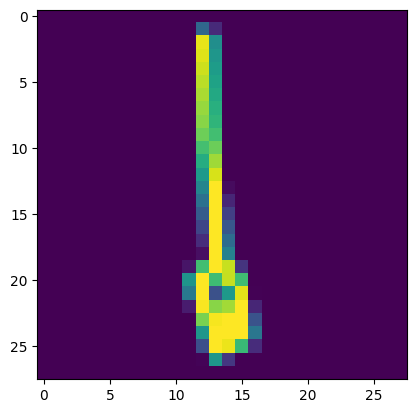

In [60]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 

In [61]:
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
print(ind)
latex = [class_names[x] for x in ind]
print(latex)

1/1 [==============================] - 0s 55ms/step
[16 76 87 74 65]
['broom', 'shovel', 'sword', 'screwdriver', 'pencil']


# Store the classes 

In [62]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Install TensorFlowJS

In [42]:
!pip install tensorflowjs 

^C


# Save and Convert 

In [77]:
model.save('keras')

INFO:tensorflow:Assets written to: hmm\assets


INFO:tensorflow:Assets written to: hmm\assets


In [ ]:
print(img)

# Zip and Download 

In [ ]:
!cp class_names.txt model/class_names.txt

In [ ]:
!zip -r model.zip model 

In [ ]:
from google.colab import files
files.download('model.zip')